In this notebook, we will show how to load pre-trained models and draw things with sketch-rnn

In [1]:
# import the required libraries
import numpy as np
import time
import random
import pickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

/home/ruben/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ruben/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ruben/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ruben/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [3]:
# !pip install -qU svgwrite

In [4]:
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [5]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)


In [6]:
# !pip install -q magenta

In [7]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

W0825 15:58:50.188074 140470926227264 deprecation_wrapper.py:119] From /home/ruben/Documents/Geboortekaartje/sketch_rnn/venv/lib/python3.7/site-packages/magenta/pipelines/statistics.py:132: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

/home/ruben/Documents/Geboortekaartje/sketch_rnn/venv/lib/python3.7/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
W0825 15:58:50.811670 140470926227264 deprecation_wrapper.py:119] From /home/ruben/Documents/Geboortekaartje/sketch_rnn/venv/lib/python3.7/site-packages/magenta/music/note_sequence_io.py:60: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0825 15:58:51.114169 140470926227264 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs

In [8]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

define the path of the model you want to load, and also the path of the dataset

In [139]:
data_dir = 'datasets/naam4'
model_dir = 'models/naam4'

In [140]:
# download_pretrained_models(models_root_dir=models_root_dir)

In [153]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [154]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

I0825 17:10:28.492715 140470926227264 sketch_rnn_train.py:142] Loaded 161/161/161 from diede.npz
I0825 17:10:28.666448 140470926227264 sketch_rnn_train.py:142] Loaded 100/100/100 from lijn.npz
I0825 17:10:29.123052 140470926227264 sketch_rnn_train.py:142] Loaded 100/100/100 from blokletters.npz
I0825 17:10:29.189439 140470926227264 sketch_rnn_train.py:159] Dataset combined: 1083 (361/361/361), avg len 234
I0825 17:10:29.190502 140470926227264 sketch_rnn_train.py:166] model_params.max_seq_len 614.


total images <= max_seq_len is 361


I0825 17:10:29.655039 140470926227264 sketch_rnn_train.py:209] normalizing_scale_factor 55.2581.


total images <= max_seq_len is 361
total images <= max_seq_len is 361


In [155]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

I0825 17:10:34.129225 140470926227264 model.py:87] Model using gpu.
I0825 17:10:34.139610 140470926227264 model.py:175] Input dropout mode = False.
I0825 17:10:34.141004 140470926227264 model.py:176] Output dropout mode = False.
I0825 17:10:34.143371 140470926227264 model.py:177] Recurrent dropout mode = False.
I0825 17:10:42.551079 140470926227264 model.py:87] Model using gpu.
I0825 17:10:42.553035 140470926227264 model.py:175] Input dropout mode = 0.
I0825 17:10:42.554712 140470926227264 model.py:176] Output dropout mode = 0.
I0825 17:10:42.556115 140470926227264 model.py:177] Recurrent dropout mode = 0.
I0825 17:10:43.679191 140470926227264 model.py:87] Model using gpu.
I0825 17:10:43.681183 140470926227264 model.py:175] Input dropout mode = 0.
I0825 17:10:43.682615 140470926227264 model.py:176] Output dropout mode = 0.
I0825 17:10:43.683944 140470926227264 model.py:177] Recurrent dropout mode = 0.


In [156]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [199]:
# loads the weights from checkpoint into our model
# load_checkpoint(sess, model_dir)
saver = tf.train.Saver(tf.global_variables())
ckpt = tf.train.get_checkpoint_state(model_dir)
print(int(ckpt.model_checkpoint_path.split("-")[-1])/100)
# tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)
saver.restore(sess, "models/naam4/vector-4100")

48.0


ValueError: The passed save_path is not a valid checkpoint: models/naam4/vector-4100

We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [159]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes, 614).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  print(seq_len)
  draw_strokes(to_normal_strokes(np.array(strokes)))
  print(np.array([strokes]).shape)
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [160]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

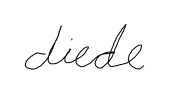

In [189]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
stroke=test_set.strokes[202]
draw_strokes(stroke)

Let's try to encode the sample stroke into latent vector $z$

[244]


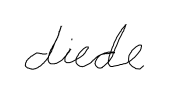

(1, 615, 5)


In [190]:
z = encode(stroke)

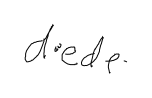

In [197]:
_ = decode(z,temperature=1) # convert z back to drawing at temperature of 0.8


Create generated grid at various temperatures from 0.1 to 1.0

0.1


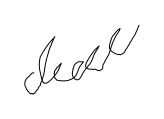

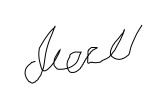

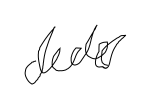

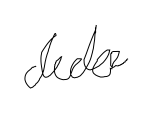

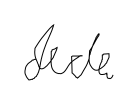

0.2


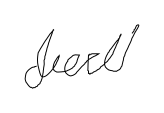

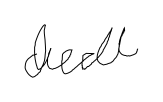

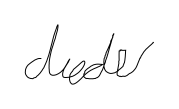

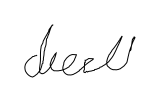

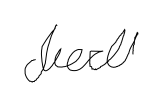

0.30000000000000004


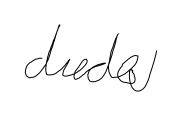

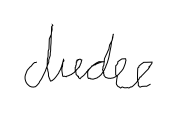

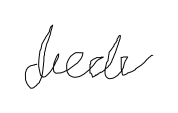

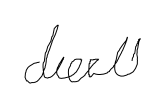

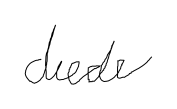

0.4


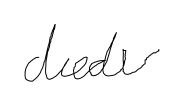

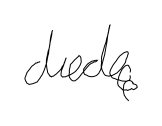

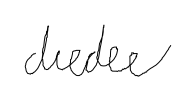

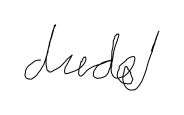

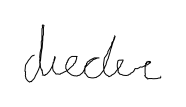

0.5


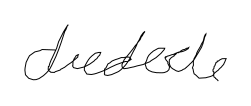

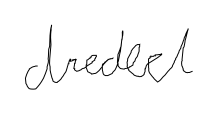

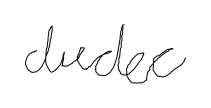

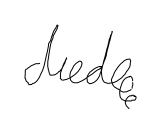

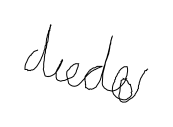

0.6


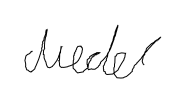

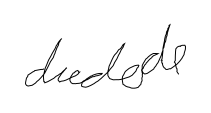

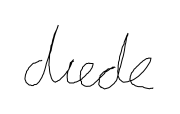

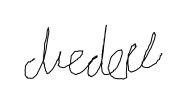

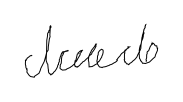

0.7000000000000001


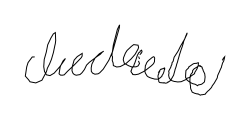

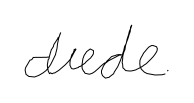

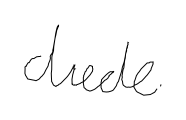

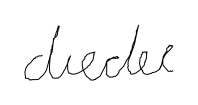

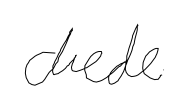

0.8


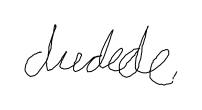

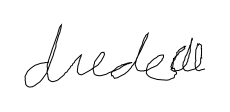

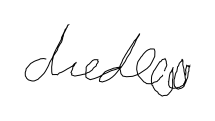

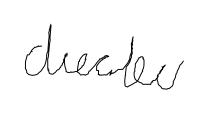

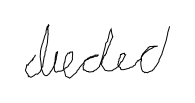

0.9


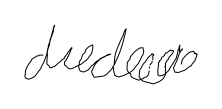

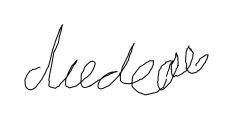

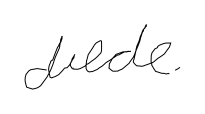

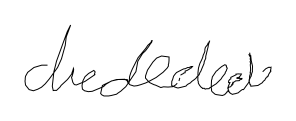

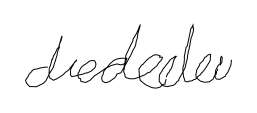

1.0


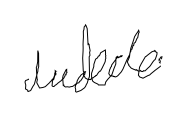

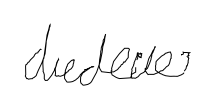

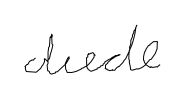

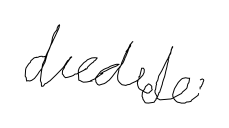

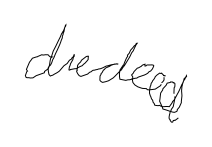

In [102]:
for i in range(10):
    temp = .1 + i*.1
    print(temp)
    for j in range(5):
        stroke = decode(draw_mode=False, temperature=temp)
        draw_strokes(stroke)
        
    
# stroke_grid = make_grid_svg(stroke_list)
# draw_strokes(stroke_grid)

Latent Space Interpolation Example between $z_0$ and $z_1$

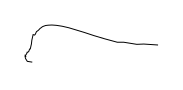

In [83]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

[425]


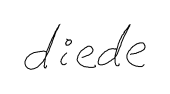

(1, 615, 5)


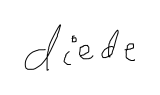

In [66]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

Now we interpolate between sheep $z_0$ and sheep $z_1$

In [84]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

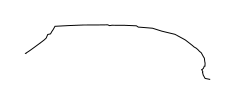

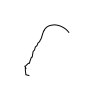

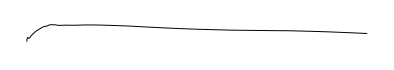

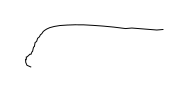

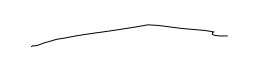

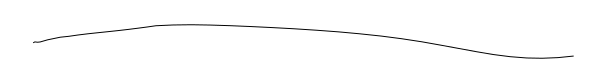

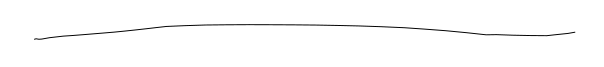

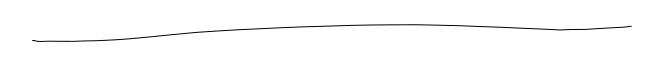

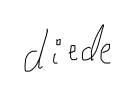

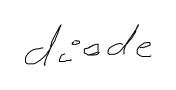

In [85]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=True), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation

In [ ]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)

In [ ]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [ ]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors

In [ ]:
model_dir = '/tmp/sketch_rnn/models/owl/lstm'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [ ]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

In [ ]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Let's interpolate between the two owls $z_0$ and $z_1$

In [ ]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the model trained on both cats and buses!  catbus!

In [ ]:
model_dir = '/tmp/sketch_rnn/models/catbus/lstm'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [ ]:
z_1 = np.random.randn(eval_model.hps.z_size)
z_1 = z
_ = decode(z_1)

In [ ]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

Let's interpolate between a cat and a bus!!!

In [ ]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 50
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Why stop here? Let's load the model trained on both elephants and pigs!!!

In [ ]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [ ]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

In [ ]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Tribute to an episode of [South Park](https://en.wikipedia.org/wiki/An_Elephant_Makes_Love_to_a_Pig): The interpolation between an Elephant and a Pig

In [ ]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)

In [ ]:
draw_strokes(stroke_grid, factor=0.3)